<a href="https://colab.research.google.com/github/pranavgupta2603/DRDO-Sprint-/blob/main/ship_feature_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/newtrain.zip

Archive:  drive/MyDrive/newtrain.zip
   creating: newtrain/Adele/
  inflating: newtrain/Adele/3361235.jpg  
  inflating: newtrain/Adele/3361237.jpg  
  inflating: newtrain/Adele/3361238.jpg  
  inflating: newtrain/Adele/3361239.jpg  
  inflating: newtrain/Adele/3361240.jpg  
   creating: newtrain/AFRICA/
  inflating: newtrain/AFRICA/1401024.jpg  
  inflating: newtrain/AFRICA/1401025.jpg  
  inflating: newtrain/AFRICA/1401026.jpg  
  inflating: newtrain/AFRICA/1401368.jpg  
   creating: newtrain/ALCATRAZ CLIPPER/
  inflating: newtrain/ALCATRAZ CLIPPER/3429318.jpg  
  inflating: newtrain/ALCATRAZ CLIPPER/3429319.jpg  
  inflating: newtrain/ALCATRAZ CLIPPER/3429320.jpg  
  inflating: newtrain/ALCATRAZ CLIPPER/3429321.jpg  
   creating: newtrain/ALFIOS/
  inflating: newtrain/ALFIOS/1626227.jpg  
  inflating: newtrain/ALFIOS/1626229.jpg  
  inflating: newtrain/ALFIOS/1626230.jpg  
  inflating: newtrain/ALFIOS/1626231.jpg  
   creating: newtrain/ALGOMA COMPASS/
  inflating: newtrain/ALGOMA C

In [ ]:
def preprocess(img):
    edges = cv2.dilate(cv2.Canny(img,0,255),None)
    cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros((150,150), np.uint8)
    masked = cv2.drawContours(mask, [cnt],-1, 255, -1)
    
    dst = cv2.bitwise_and(img, img, mask=mask)
    a = np.concatenate((img, dst), axis=1)
    return dst

In [ ]:
x = []
y = []
#y = np.array(list(df["label"]))
path = "./newtrain/"
use = sorted(glob.glob(os.path.join(path+"/*/*")))
for i in use:
  #print(i)
  im = cv2.imread(i)
  im = cv2.resize(im, (150, 150))
  im = preprocess(im)
  x.append(im)
  y.append(i.split("/")[2])


In [ ]:
print(len(y))


925


In [ ]:
x = np.array(x)
x_train = x/255.
print(x_train.shape)

(925, 150, 150, 3)


In [ ]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (150, 150, 3)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

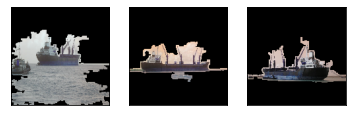

In [ ]:
plot_triplets([x_train[0], x_train[1], x_train[2]])


In [ ]:
def create_batch(x_train, y_train, batch_size=256):
    x_anchors = np.zeros((batch_size, 150, 150, 3))
    x_positives = np.zeros((batch_size, 150, 150, 3))
    x_negatives = np.zeros((batch_size, 150, 150, 3))
    
    for i in range(0, batch_size):
        
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        
        x_anchor = x_train[random_index]
        
        y = y_train[random_index]
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

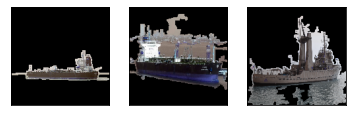

In [ ]:
y = np.array(y)
examples = create_batch(x_train, y, 1)
plot_triplets(examples)

In [ ]:
from tensorflow.keras.applications import InceptionV3

image_model = tf.keras.applications.InceptionV3(input_shape=(150, 150, 3), include_top=False, weights="imagenet")   # weights=None for random initialization
last_layer = image_model.get_layer('mixed1')
output = last_layer.output
x = tf.keras.layers.Flatten()(output)
#x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128,activation='sigmoid')(x)
image_features_extract_model = tf.keras.Model(image_model.input, x)
image_features_extract_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_470 (Conv2D)            (None, 74, 74, 32)   864         ['input_18[0][0]']               
                                                                                                  
 batch_normalization_470 (Batch  (None, 74, 74, 32)  96          ['conv2d_470[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [ ]:
with tf.device('/device:GPU:0'):
  example = np.expand_dims(x_train[1], axis=0)
  example_emb = image_features_extract_model.predict(example)[0]

print(example_emb)


[0.27207687 0.26634577 0.9615212  0.354293   0.1517079  0.30955976
 0.11905695 0.494602   0.11928628 0.19192275 0.6922378  0.9289889
 0.21719205 0.09939773 0.07610585 0.7179958  0.6185465  0.21080405
 0.63852483 0.09290619 0.8483993  0.759076   0.5172856  0.20189647
 0.93832767 0.31911033 0.5102874  0.56756806 0.6799362  0.44121078
 0.68574387 0.54609126 0.04638658 0.1175889  0.7052545  0.966989
 0.97628266 0.4268885  0.4524587  0.4084662  0.89003956 0.46379703
 0.652959   0.2763942  0.55965    0.35202765 0.53024    0.6012671
 0.4898339  0.3682042  0.851868   0.22605266 0.436209   0.57833385
 0.6059095  0.18351527 0.45996875 0.7442625  0.89365995 0.28867346
 0.7049094  0.67548    0.9147228  0.18776463 0.40380234 0.8944173
 0.7544851  0.5249548  0.9483501  0.1933532  0.21317941 0.29630145
 0.43116435 0.14782909 0.68130744 0.43552384 0.30954477 0.34450233
 0.5535009  0.9018777  0.47626337 0.86311704 0.7305565  0.23754063
 0.26211032 0.5516894  0.5889982  0.8006534  0.8577336  0.51027715


In [ ]:
input_anchor = tf.keras.layers.Input(shape=(150,150,3))
input_positive = tf.keras.layers.Input(shape=(150,150,3))
input_negative = tf.keras.layers.Input(shape=(150,150,3))

embedding_anchor = image_features_extract_model(input_anchor)
embedding_positive =image_features_extract_model(input_positive)
embedding_negative = image_features_extract_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_16 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_17 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                          

In [ ]:
alpha = 0.1
emb_size = 128
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [ ]:
def data_generator(x_train, y,batch_size=256):
    while True:
        x_use = create_batch(x_train, y, batch_size)
        y_use = np.zeros((batch_size, 3*emb_size))
        yield x_use, y_use

In [ ]:
batch_size = 32
epochs = 20
steps_per_epoch = int(x_train.shape[0]/batch_size)
with tf.device('/device:GPU:0'):
  net.compile(loss=triplet_loss, optimizer='adam')

  _ = net.fit(
      data_generator(x_train, y, batch_size),
      steps_per_epoch=steps_per_epoch,
      epochs=epochs, verbose=True)

Epoch 1/20
28/28 [==============================] - 8s 145ms/step - loss: 0.0982
Epoch 2/20
28/28 [==============================] - 4s 144ms/step - loss: 0.0975
Epoch 3/20
28/28 [==============================] - 4s 145ms/step - loss: 0.0975
Epoch 4/20
28/28 [==============================] - 4s 145ms/step - loss: 0.0971
Epoch 5/20
28/28 [==============================] - 4s 146ms/step - loss: 0.0959
Epoch 6/20
28/28 [==============================] - 4s 146ms/step - loss: 0.0967
Epoch 7/20
28/28 [==============================] - 4s 148ms/step - loss: 0.0854
Epoch 8/20
28/28 [==============================] - 4s 147ms/step - loss: 0.0716
Epoch 9/20
28/28 [==============================] - 4s 147ms/step - loss: 0.0616
Epoch 10/20
28/28 [==============================] - 4s 146ms/step - loss: 0.0594
Epoch 11/20
28/28 [==============================] - 4s 146ms/step - loss: 0.0620
Epoch 12/20
28/28 [==============================] - 4s 145ms/step - loss: 0.0582
Epoch 13/20
28/28 [======

In [ ]:
model = net


In [ ]:
example = np.expand_dims(x_train[1], axis=0)
example_emb = image_features_extract_model.predict(example)[0]
print(example_emb)


[2.3305474e-04 6.9209360e-05 9.9996161e-01 9.9995637e-01 1.9666116e-04
 1.0000000e+00 9.9999583e-01 9.9606508e-01 9.9991870e-01 1.5941181e-04
 7.3247678e-03 5.4197828e-04 4.1341622e-07 9.9984348e-01 6.6474644e-03
 3.8582894e-01 2.2182742e-01 2.3400403e-07 1.1506871e-05 9.9995136e-01
 2.9360077e-05 2.5464280e-06 6.7739970e-06 2.4048131e-06 9.8289317e-01
 9.6173441e-01 9.9985456e-01 9.9999189e-01 3.9213097e-05 9.9994922e-01
 9.9986613e-01 9.9941230e-01 8.5337018e-07 9.9996126e-01 4.7519872e-08
 9.9999785e-01 9.9926573e-01 9.9999428e-01 1.6349615e-05 4.0240982e-05
 9.9822491e-01 9.9999583e-01 1.2757132e-03 7.6525472e-04 1.0000000e+00
 9.9933404e-01 9.7848815e-01 9.9999833e-01 1.1654145e-03 9.9999678e-01
 9.9999964e-01 9.9999535e-01 3.5827581e-03 8.2844895e-07 9.9998939e-01
 7.4300045e-01 4.9328992e-05 5.0223836e-05 4.0425198e-06 9.9999893e-01
 9.9956745e-01 9.9999321e-01 7.3562011e-02 9.9998724e-01 9.9997425e-01
 9.9999857e-01 9.9998629e-01 1.1600969e-04 9.9999988e-01 9.9998534e-01
 9.999

In [ ]:
from tensorflow.keras.models import Model
#net.save("net.h5")
image_features_extract_model.save("drive/MyDrive/shipsmodel_segm.h5")

In [ ]:
from tensorflow.keras.models import load_model
image_features_extract_model = load_model("drive/MyDrive/shipsmodel_segm.h5")

In [ ]:
!unzip drive/MyDrive/val.zip

In [ ]:
testx = []
testy = []
#y = np.array(list(df["label"]))
path = "./val/"
use = sorted(glob.glob(os.path.join(path+"/*/*")))
for i in use:
  im = cv2.imread(i)
  im = cv2.resize(im, (150, 150))
  im = preprocess(im)
  testx.append(im)
  testy.append(i.split("/")[2])


In [ ]:
print(len(testy))
testx = np.array(testx)
testy = np.array(testy)

x_test = testx/255.
print(x_test.shape)

522
(522, 150, 150, 3)


In [ ]:
anchors, pos, neg = create_batch(x_test, testy, batch_size = 512)
total = batch_size*2

In [ ]:
net.predict(data_generator(x_train, y, batch_size))

KeyboardInterrupt: ignored

In [ ]:

all_a = []
all_p = []
all_n = []
for i in range(0, len(pos)):
    a = anchors[i]
    a = np.expand_dims(a, axis=0)
    p = pos[i]
    p = np.expand_dims(p, axis=0)
    n = neg[i]
    n = np.expand_dims(n, axis=0)
    a_emb = image_features_extract_model.predict(a)[0]
    all_a.append(a_emb)
    p_emb = image_features_extract_model.predict(p)[0]
    all_p.append(p_emb)
    n_emb = image_features_extract_model.predict(n)[0]
    all_n.append(n_emb)

In [ ]:
distances_pos = []
distances_neg = []
true_accept = 0
false_accept = 0
true_decline = 0
false_decline = 0
thresh = 6.0
for i in range(0, len(all_a)):
  a_emb = all_a[i]
  p_emb = all_p[i]
  n_emb = all_n[i]
  dist1 = np.linalg.norm(a_emb-p_emb)
  dist2 = np.linalg.norm(a_emb-n_emb)
  distances_pos.append(dist1)
  distances_neg.append(dist2)
  if dist1 < thresh:
      true_accept += 1
  else:
      false_accept += 1
  if dist2 > thresh:
      true_decline += 1
  else:
      false_decline += 1
distances_pos = np.array(distances_pos)
distances_neg = np.array(distances_neg)

In [ ]:
print(np.mean(distances_pos, axis=0))
print(np.mean(distances_neg, axis=0))

#print(true_accept, false_accept)
#print(true_decline, false_decline)
#print((true_accept + true_decline)/1024)

0.20112693
0.631008


In [ ]:
threshs = []
i = 0;
while i < 1.00:
    i = round(i, 2)
    threshs.append(i)
    i += 0.05
    print(i)
print(threshs)
print(len(threshs))

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35
0.39999999999999997
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
20


In [ ]:
def results(all_a, all_p, all_n, thresh):
    true_accept = 0
    false_accept = 0
    true_decline = 0
    false_decline = 0
    for i in range(0, len(pos)):
        a_emb = all_a[i]
        p_emb = all_p[i]
        n_emb = all_n[i]
        dist1 = np.linalg.norm(a_emb-p_emb)
        dist2 = np.linalg.norm(a_emb-n_emb)
        if dist1 < thresh:
            true_accept += 1
        else:
            true_decline += 1
        if dist2 > thresh:
            false_accept += 1
        else:
            false_decline += 1
    return true_accept, false_accept, true_decline, false_decline


In [ ]:
all_ta = []
all_fa = []
all_td = []
all_fd  = []

for thresh in threshs:
    ta, fa, td, fd = results(all_a, all_p, all_n, thresh)
    print(thresh)
    print(ta, fa)
    print(td, fd)
    print((ta + fa)/1024)
    print("*****")
    all_ta.append(ta)
    all_fa.append(fa)
    all_td.append(td)
    all_fd.append(fd)
    


0
0 512
512 0
0.5
*****
0.05
194 512
318 0
0.689453125
*****
0.1
215 510
297 2
0.7080078125
*****
0.15
243 503
269 9
0.728515625
*****
0.2
277 492
235 20
0.7509765625
*****
0.25
321 471
191 41
0.7734375
*****
0.3
359 443
153 69
0.783203125
*****
0.35
391 416
121 96
0.7880859375
*****
0.4
420 373
92 139
0.7744140625
*****
0.45
440 338
72 174
0.759765625
*****
0.5
458 314
54 198
0.75390625
*****
0.55
469 274
43 238
0.7255859375
*****
0.6
484 245
28 267
0.7119140625
*****
0.65
498 217
14 295
0.6982421875
*****
0.7
502 195
10 317
0.6806640625
*****
0.75
507 163
5 349
0.654296875
*****
0.8
510 142
2 370
0.63671875
*****
0.85
512 114
0 398
0.611328125
*****
0.9
512 99
0 413
0.5966796875
*****
0.95
512 79
0 433
0.5771484375
*****


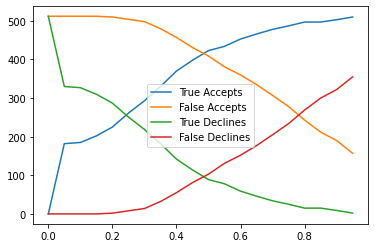

In [ ]:
plt.plot(threshs, all_ta, label="True Accepts")
plt.plot(threshs, all_fa, label="False Accepts")
plt.plot(threshs, all_td, label="True Declines")
plt.plot(threshs, all_fd, label="False Declines")
plt.legend()
plt.show()
